# Imports

## Add path to our development module to sys.path

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
from importlib import reload
import adaptive_confound.utils as acu
import adaptive_confound.control as acc
import adaptive_confound.topic_model as actm

/home/virgile/.conda/envs/py36/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/virgile/.conda/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Normal imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sp
import pickle
import os.path
import tensorflow as tf
import itertools as it

from datetime import datetime
from tqdm import tqdm
from sklearn import metrics, preprocessing
from copy import deepcopy
from scipy.stats import mode
from collections import Counter, defaultdict

In [3]:
from keras import backend as K
from keras.layers import Dense, Input, Lambda
from keras.models import Model, Sequential
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.datasets import reuters
from keras.losses import binary_crossentropy, mse

In [4]:
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
sess = tf.Session(config=config)
set_session(sess)

In [5]:
pd.options.display.max_colwidth = 200
pd.options.display.max_columns = 100

# Load data

## Twitter gender/location data

In [6]:
ystr = 'location'
zstr = 'gender'

In [46]:
twitter = acu.read_pickle("/data/virgile/confound/adaptive/in/twitter_dataset_y={}_z={}.pkl".format(ystr, zstr))

In [47]:
twitter.create_biased_datasets(1000, np.linspace(.1,.9,9), k=1)

## Yelp data

In [9]:
yelp = acu.read_pickle("/data/virgile/confound/adaptive/in/balanced_yelp.pkl")

In [339]:
yelp

< Dataset: size=14128, p(y)=0.50, p(z)=0.50, bias=0.50, parent=< Dataset: size=57342, p(y)=0.78, p(z)=0.73, bias=0.79, parent=None > >

# Topic models benchmark

In [ ]:
n_topics = 100
models = [
    actm.DenseNeuralNet(k=twitter.features.size, m=n_topics),
    actm.VariationalAutoEncoder(k=twitter.features.size, m=n_topics, 
                                model_params=dict(hidden_dim=n_topics, beta=1, supervised=False)),
    actm.LatentDirichletAllocation(k=twitter.features.size, m=n_topics)
]
list_kwargs = [
    dict(epochs=100, verbose=0),
    dict(epochs=100, verbose=0),
    dict()
]

product_dataset = it.product(
    twitter.get_biased_datasets(kind='train'),
    twitter.get_biased_datasets(kind='test')
)
iterator = tqdm( list( enumerate( product_dataset ) ) )
savedir = "/data/virgile/confound/adaptive/out/twitter/datasets_with_topic_distrib/{}"

for i, (d_train, d_test) in iterator:
    full_d = acu.dataset.concat([d_train, d_test])
    d_train.topics = {}
    d_test.topics = {}
    d_train_path = savedir.format("d_train_{:03d}.pkl".format(i))
    d_test_path = savedir.format("d_test_{:03d}.pkl".format(i))
    for tm, kwargs in zip(models, list_kwargs):
        tm.fit(full_d, **kwargs)
        tm_name = tm.get_name()
        d_train.topics[tm_name] = tm.transform(d_train)
        d_test.topics[tm_name] = tm.transform(d_test)
    d_train.to_pickle(d_train_path, with_parent=False)
    d_test.to_pickle(d_test_path, with_parent=False)


  0%|          | 0/81 [00:00<?, ?it/s]


In [42]:
from sklearn import metrics
results['f1'] = results.apply(lambda r: metrics.f1_score(r.y_true, r.y_pred), axis=1)
results['acc'] = results.apply(lambda r: metrics.accuracy_score(r.y_true, r.y_pred), axis=1)

In [43]:
results['corr_diff'] = results.tr_corr - results.te_corr
results['corr_diff_round'] = results.corr_diff.round(1)

In [45]:
results.groupby(['classifier', 'z_i', 'corr_diff_round', 'z_i']).f1.mean()

classifier          z_i  corr_diff_round  z_i
BackdoorAdjustment  0    -1.6             0      0.712099
                         -1.2             0      0.788196
                         -0.8             0      0.822580
                         -0.4             0      0.845131
                          0.0             0      0.855025
                          0.4             0      0.865866
                          0.8             0      0.851304
                          1.2             0      0.825668
                          1.6             0      0.783084
LogisticRegression  0    -1.6             0      0.622322
                         -1.2             0      0.747925
                         -0.8             0      0.820578
                         -0.4             0      0.862361
                          0.0             0      0.883075
                          0.4             0      0.861958
                          0.8             0      0.821431
                          

In [15]:
results.head()

,classifier,te_corr,topic_model,tr_corr,y_pred,y_true,z_i,f1,corr_diff,corr_diff_round
0,BackdoorAdjustment,-0.822216,TrueTopic,-0.776347,"[0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, ...","[0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, ...",0,0.878728,0.045869,0.0
1,LogisticRegression,-0.822216,None,-0.776347,"[0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, ...","[0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, ...",0,0.875248,0.045869,0.0
2,BackdoorAdjustment,-0.418157,TrueTopic,-0.776347,"[0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, ...","[0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, ...",0,0.842002,-0.358190,-0.4
3,LogisticRegression,-0.418157,None,-0.776347,"[0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, ...","[0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, ...",0,0.823069,-0.358190,-0.4
4,BackdoorAdjustment,-0.016131,TrueTopic,-0.776347,"[1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, ...","[1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...",0,0.795205,-0.760217,-0.8


In [150]:
results.to_json("/data/virgile/confound/adaptive/out/twitter/dnn_vs_truetopic.jsonl", lines=True, orient='records')

In [103]:
twitter.X.sum(axis=0).A1

array([2084, 3316,  207, ...,  116,  133,  127], dtype=int64)

In [169]:
def compute_pxgxi(d):
    n, k = d.X.shape
    result = np.ones((k,k))
    sum_fts = 1 + d.X.sum(axis=0).A1
    for xi in tqdm(range(k)):
        if sp.issparse(d.X):
            keep = d.X[:, xi].nonzero()[0]
        else:
            keep = np.where(d.X[:, xi] != 0)[0]
        result[xi] += d.X[keep].sum(axis=0).A1
    return result

In [170]:
compute_pxgxi(d_train)

100%|██████████| 21981/21981 [05:32<00:00, 66.21it/s] 


array([[ 335.,  234.,   20., ...,    9.,   11.,   10.],
       [ 234.,  565.,   38., ...,   14.,   17.,   17.],
       [  20.,   38.,   41., ...,    3.,    3.,    2.],
       ..., 
       [   9.,   14.,    3., ...,   21.,    4.,    1.],
       [  11.,   17.,    3., ...,    4.,   22.,    1.],
       [  10.,   17.,    2., ...,    1.,    1.,   22.]])

In [171]:
from sklearn.decomposition import LatentDirichletAllocation

In [184]:
lda = LatentDirichletAllocation(n_components=30, learning_method="batch", batch_size=100)
lda.fit(d_train.X)

LatentDirichletAllocation(batch_size=100, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=30, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [187]:
ttrain = lda.transform(d_train.X)

In [195]:
import pyLDAvis

In [196]:
pyLDAvis.enable_notebook()

In [198]:
import pyLDAvis.sklearn

In [ ]:
pyLDAvis.display(pyLDAvis.sklearn.prepare(lda, d_train.X, twitter.vectorizer, mds='mmds'))

/home/virgile/.conda/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


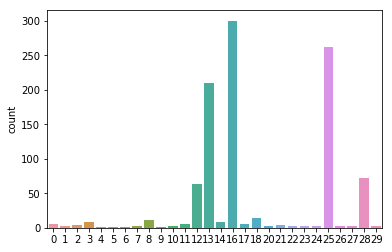

In [192]:
sns.countplot(ttrain.argmax(axis=1))

In [188]:
ttest = lda.transform(d_test.X)

In [186]:
lda.perplexity(d_train.X)

12863.88940417501

In [185]:
lda.perplexity(d_test.X)

13496.632913821431

# Shifting topics discovery

## Run experiment that blocks one topic and return the prediction

In [11]:
def make_predictions_per_topic(model, weights_idx, X_test):
    weights_og = model.get_weights()
    
    ntopics = weights_og[weights_idx].shape[0]
    preds = []
    for ti in tqdm(list(range(ntopics))):
        weights = deepcopy(weights_og)
        weights[-2][ti] = 0
        model.set_weights(weights)
        preds.append(model.predict(X_test))
    
    model.set_weights(weights_og)
    
    preds = np.hstack(preds)
    return preds

In [12]:
# preds_per_topic = make_predictions_per_topic(vae_topicmodel.topic_model, 2, yelp.X[idx_bias09])
preds_per_topic = make_predictions_per_topic(dnn_clf.pred_model, 2, yelp.X[idx_bias09])

 10%|█         | 5/50 [00:03<00:29,  1.52it/s]


KeyboardInterrupt: 

In [184]:
preds_per_topic_int = np.around(preds_per_topic).astype(int)

In [185]:
mode_per_instance = mode(preds_per_topic_int, axis=1)[0]

In [186]:
changes_per_topic = (preds_per_topic_int != mode_per_instance).sum(axis=0)

In [187]:
topic_weights = dnn_clf.pred_model.get_weights()[2].flatten()

In [188]:
weights = dnn_clf.pred_model.get_weights()
pd.DataFrame([{
    '1. Topic': idx,
    '2. Weight': topic_weights[idx],
    '3. # Changes': changes_per_topic[idx],
    '4. Top Words': ", ".join(yelp.feature_names[weights[0][:,idx].argsort()[::-1]][:30])
} for idx in topic_weights.argsort()])

,1. Topic,2. Weight,3. # Changes,4. Top Words
0,34,-13.493729,2606,"mediocre, rude, worst, horrible, terrible, bland, disappointing, poor, okay, ok, tasted, dirty, slow, sorry, shame"
1,44,-2.783704,0,"northwest, merlot, iteration, distraction, sever, german, macadamia, indians, drizzling, cambria, seam, sprays, hazelnuts, bah, bra"
2,23,-2.636929,0,"adobo, connie, dairy, crema, occurs, carafe, beds, baltimore, antney, ante, dishes, lemony, fusion, distilled, 6ish"
3,21,-1.839704,0,"noun, losers, biscotti, carve, disguised, deposit, tavern, keeps, hibachi, trophy, lindsay, umami, upstairs, bombers, friends"
4,39,-1.816739,0,"approach, wristband, hazy, sal, täkō, socialize, profound, remedy, butcher, exceedingly, hitch, mont, babaganoush, technical, rack"
5,4,-1.465101,0,"camera, swell, igloo, fluent, tataki, motioned, stews, alejandro, male, customization, moly, wonton, sung, morons, wowed"
6,38,-1.240233,0,"bake, introduction, satisfied, preventing, bark, conscious, hyperbole, orgasm, cho, ragout, stairs, liquors, crummy, slider, ali"
7,43,-1.170576,0,"jerked, unlucky, moly, minimize, jules, malty, pterodactyl, kart, fundido, wanted, rice, unsuccessfully, cheerwine, unorganized, cavities"
8,7,-1.123191,0,"saks, lite, hay, desperately, dirtiest, snag, tamago, tamara, tractor, vacation, roethlisburger, mandy, venti, vinegary, plumber"
9,9,-1.063330,0,"repetitive, bird, empanada, fast, soundproofing, tuscany, swallowed, vacate, aw, legally, inca, dank, alarmed, hometown, malty"


# VAE model

In [190]:
reload(actm)

<module 'adaptive_confound.topic_model' from '/home/virgile/adaptive_confound/adaptive_confound/topic_model/__init__.py'>

In [288]:
vae = actm.VariationalAutoEncoder(
    k=twitter.features.size,
    m=30, 
    model_params=dict(
        hidden_dim=100,
        beta=1,
        supervised=False
    )
)

In [215]:
a = vae.topic_model.weights[0]
b = vae.topic_model.weights[2]
tw = sess.run(tf.tensordot(a, b, [[1],[0]]))

In [216]:
# tw = sess.run(vae_topicmodel.topic_model.weights[0])
tw.shape

(21981, 30)

In [224]:
np.where(twitter.features == 'basketball')[0][0]

2025

2025 basketball


<Container object of 30 artists>

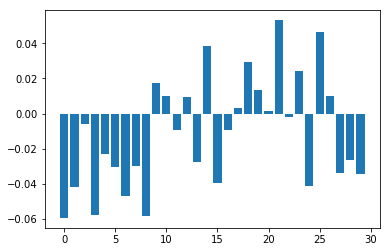

In [226]:
fti = np.where(twitter.features == 'basketball')[0][0] #np.random.choice(range(yelp.feature_names.size))
print(fti, twitter.features[fti])
plt.bar(range(tw.shape[1]), tw[fti])

In [227]:
t = []
for i in range(tw.shape[1]):
    top_fts_idx = tw[:,i].argsort()[::-1][:20]
    words = ["{} [{:.2e}]".format(word, weight) for word, weight in zip(twitter.features[top_fts_idx], tw[:,i][top_fts_idx])]
    t.append(words)
pd.DataFrame(t).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,needs [3.91e-01],needs [3.75e-01],sunset [1.74e-01],needs [3.29e-01],needs [4.08e-01],ranch [2.62e-01],needs [2.65e-01],sunset [2.15e-01],needs [3.84e-01],argentina [8.58e-02],romance [6.62e-02],sneezing [5.39e-02],ahhhhh [1.36e-01],needs [2.09e-01],heavy [1.31e-01],needs [2.40e-01],needs [2.42e-01],sourcing [5.22e-02],hair [8.45e-02],smallest [7.48e-02],jerk [7.31e-02],2010 [1.43e-01],cyclists [6.14e-02],forward [9.12e-02],needs [2.56e-01],lack [1.59e-01],dias [9.00e-02],needs [2.87e-01],ranch [2.77e-01],jurassic [5.62e-02]
1,ranch [3.50e-01],mother [3.39e-01],needs [1.72e-01],sunset [3.18e-01],ranch [4.05e-01],mother [2.60e-01],ranch [2.65e-01],ranch [2.10e-01],ranch [3.68e-01],hmmmmm [8.36e-02],cleaning [6.57e-02],resisting [5.08e-02],appreciated [1.31e-01],ranch [2.07e-01],outta [1.30e-01],ranch [2.23e-01],sunset [2.21e-01],fcc [5.06e-02],research [8.12e-02],left [7.29e-02],favorites [6.46e-02],killed [1.41e-01],threads [5.74e-02],shows [9.12e-02],ranch [2.49e-01],contract [1.55e-01],artist [8.95e-02],mother [2.86e-01],needs [2.39e-01],rec [5.62e-02]
2,sunset [3.45e-01],sunset [3.39e-01],mother [1.70e-01],ranch [3.14e-01],mother [3.98e-01],needs [2.55e-01],mother [2.62e-01],needs [2.09e-01],mother [3.62e-01],removed [7.51e-02],nut [6.44e-02],cielo [4.80e-02],patience [1.28e-01],mother [2.02e-01],billboard [1.21e-01],mother [2.08e-01],ranch [2.20e-01],amar [4.90e-02],facebook [7.75e-02],shazam [7.26e-02],ahhhhh [6.30e-02],horrible [1.41e-01],slideshare [5.40e-02],post [9.01e-02],mother [2.44e-01],2010 [1.52e-01],kit [8.66e-02],ranch [2.70e-01],mother [2.34e-01],bird [5.06e-02]
3,mother [3.44e-01],ranch [3.27e-01],ranch [1.64e-01],mother [3.07e-01],sunset [3.78e-01],sunset [2.30e-01],sunset [2.49e-01],mother [1.98e-01],sunset [3.22e-01],praying [7.18e-02],gosling [6.38e-02],kik [4.72e-02],sundays [1.27e-01],kiss [1.92e-01],kit [1.17e-01],sunset [1.98e-01],mother [2.10e-01],cafe [4.81e-02],cafe [7.75e-02],dipped [7.03e-02],grandpa [5.95e-02],unless [1.40e-01],sochi [5.33e-02],lt [8.91e-02],sunset [2.19e-01],thankfully [1.51e-01],frozen [8.61e-02],kiss [2.69e-01],sunset [2.33e-01],highschoolsuckz [5.02e-02]
4,kiss [3.13e-01],kiss [3.14e-01],kiss [1.52e-01],kiss [3.00e-01],kiss [3.60e-01],kiss [2.00e-01],kiss [2.39e-01],kiss [1.71e-01],kiss [3.16e-01],dre [7.17e-02],nutella [6.36e-02],indictment [4.62e-02],billboard [1.26e-01],sunset [1.83e-01],patience [1.14e-01],kiss [1.76e-01],kiss [2.08e-01],nears [4.72e-02],loves [7.72e-02],da [7.02e-02],hasn [5.88e-02],roll [1.39e-01],kahn [5.20e-02],holler [8.76e-02],kiss [2.17e-01],cooler [1.50e-01],grand [8.47e-02],sunset [2.57e-01],kiss [2.11e-01],conspiracyimage [4.80e-02]
5,yesterday [2.15e-01],hershey [1.84e-01],empowering [7.15e-02],empowering [1.86e-01],awesome [2.21e-01],picture [1.19e-01],picture [9.85e-02],picture [8.51e-02],picture [1.76e-01],zeppelin [7.10e-02],bbq [6.35e-02],cedar [4.61e-02],cooler [1.25e-01],educate [1.09e-01],hood [1.13e-01],yesterday [9.90e-02],educate [1.02e-01],pelican [4.72e-02],foursquare [7.67e-02],bali [6.99e-02],gigs [5.85e-02],iggy [1.35e-01],compact [5.01e-02],era [8.64e-02],picture [8.20e-02],industry [1.49e-01],haha [8.46e-02],hershey [1.60e-01],implications [1.18e-01],shawshank [4.78e-02]
6,working [1.88e-01],picture [1.71e-01],sa [6.51e-02],yesterday [1.76e-01],picture [2.09e-01],jurassic [1.18e-01],manti [9.32e-02],empowering [7.50e-02],yesterday [1.51e-01],lead [7.02e-02],backwards [6.23e-02],registering [4.56e-02],sc [1.24e-01],awesome [8.49e-02],heads [1.13e-01],hershey [9.83e-02],picture [9.78e-02],demonstrates [4.67e-02],hopes [7.63e-02],candidate [6.94e-02],silicon [5.73e-02],contract [1.33e-01],nyc [4.99e-02],sad [8.50e-02],hershey [7.46e-02],bat [1.48e-01],lo [8.37e-02],empowering [1.46e-01],picture [1.17e-01],upppp [4.75e-02]
7,picture [1.81e-01],yesterday [1.67e-01],educate [6.51e-02],awesome [1.71e-01],yesterday [1.90e-01],yesterday [1.14e-01],educ